# Substructure matching
RdKit provides multiple ways to search substructures in a molecule. In this demo, we will review the most common ones. 

In RdKit, a molecule is represented as a graph in which the nodes are atoms and the edges are bonds. Each atom has a several properties, including its atomic number, atomic weight, charge, and the number of attached hydrogens. 

Molecule's graph representation
<div>
<img src="./fig/mol_graph.png" width="50%", height="50%">
</div>

1. Substructure matching using SMARTS
2. Substructure matching using rooted fingerprints
3. Substructure matching using RdKit's FilterCatalog
4. Synple's substructure filtering function


| Reference: ECFP https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md

In [77]:
# import modules
from typing import Tuple, List, Dict, Union, Any, Optional
import pandas as pd 
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, MolFromSmarts, rdFingerprintGenerator, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.FilterCatalog import SmartsMatcher

%matplotlib inline
IPythonConsole.ipython_useSVG=True 

## 1. Substructure matching using SMARTS

Here, we use an example of ibuprofen to demonstrate how to use SMARTS to search substructures in a molecule.

In [79]:
def get_first_hit_atoms_bonds(target_mol: Mol, sub_mol: Mol) -> Tuple:
    """
    Get the first hit atoms and bonds of substructure in target molecule
    
    Args: 
        target_mol (Mol): target molecule
        sub_mol (Mol): substructure molecule
        
    Returns:
        hit_atoms (Tuple): the first set of hit atoms of substructure in target molecule
        hit_bonds (List): hit bonds of substructure in target molecule
    """
    hit_atoms = target_mol.GetSubstructMatches(sub_mol)[0]
    hit_bonds = []
    for bond in sub_mol.GetBonds():
        aid1 = hit_atoms[bond.GetBeginAtomIdx()]
        aid2 = hit_atoms[bond.GetEndAtomIdx()]
        hit_bonds.append(target_mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    return hit_atoms, hit_bonds

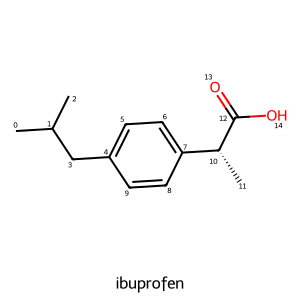

In [78]:
# define a molecule and a substructure
ibuprofen = MolFromSmiles('CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O')
# draw the molecule with atom indices
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
Draw.MolToImage(ibuprofen,legend="ibuprofen",options=opts)

In [80]:
carboacid = MolFromSmarts('[O;H,-]C=O')
# find the atom indices of the carboxyl group
hit_atoms, hit_bonds = get_first_hit_atoms_bonds(ibuprofen, carboacid)
print(f"Hit atims: {hit_atoms}")
print(f"Hit bonds: {hit_bonds}")

Hit atims: (14, 12, 13)
Hit bonds: [13, 12]


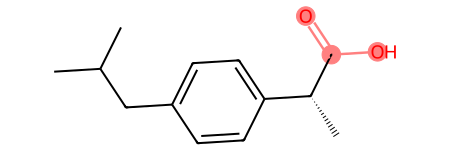

In [82]:
# draw the molecule with the substructure highlighted
d = Draw.rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, ibuprofen, highlightAtoms=hit_atoms,highlightBonds=hit_bonds)
ibuprofen

In [10]:
# Let's have a closer look at what happened here
# First, we get the substructure matches
matches = ibuprofen.GetSubstructMatches(carboacid)
print(f"Matches: {matches}")

Matches: ((14, 12, 13),)


In [11]:
# Then, we find the atom indices and the corresponding bonds of the first match
hit_atoms = matches[0]
hit_bonds = []
for bond in carboacid.GetBonds():
    aid1 = hit_atoms[bond.GetBeginAtomIdx()]
    aid2 = hit_atoms[bond.GetEndAtomIdx()]
    hit_bonds.append(ibuprofen.GetBondBetweenAtoms(aid1,aid2).GetIdx())
print(f"Hit atims: {hit_atoms}")
print(f"Hit bonds: {hit_bonds}")

Hit atims: (14, 12, 13)
Hit bonds: [13, 12]


## 2. Substructure matching using rooted fingerprints

Here, instead of providing a SMARTS pattern, we use a molecule to search substructures in another molecule.

In RDkit, you can generate a rooted fingerprint for a molecule. The rooted fingerprint is a bit vector that encodes the substructures of a molecule. Each bit corresponds to a substructure. If the substructure is present in the molecule, the bit is set to 1. Otherwise, the bit is set to 0.

In [40]:
def draw_substructure_highlighted_mol(mol, sub):
    hit_atoms, hit_bonds = get_first_hit_atoms_bonds(mol, sub)
    d = Draw.rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_atoms,highlightBonds=hit_bonds)
    return mol

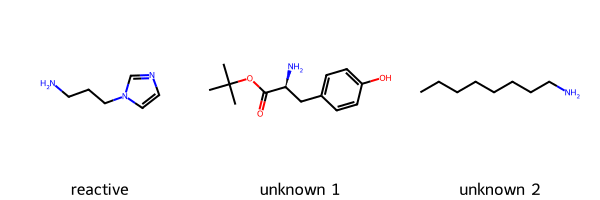

In [39]:
a1 = MolFromSmiles('NCCCN1C=CN=C1')
a2 = MolFromSmiles('O=C(OC(C)(C)C)[C@@H](N)CC1=CC=C(O)C=C1')
a3 = MolFromSmiles('NCCCCCCCC')
Draw.MolsToGridImage([a1,a2,a3], legends=["reactive", "unknown 1", "unknown 2"])

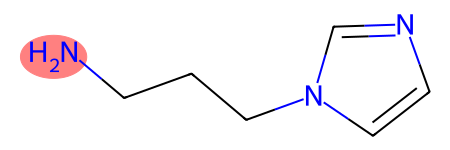

In [45]:
# amine smarts
amine =  MolFromSmarts("[N;!H0;$(N-[#6]);!$(N-[!#6;!#1;!#7]);!$(N-C=[O,N,S])]")
a1 = draw_substructure_highlighted_mol(a1, amine)
a2 = draw_substructure_highlighted_mol(a2, amine)
a3 = draw_substructure_highlighted_mol(a3, amine)
a1

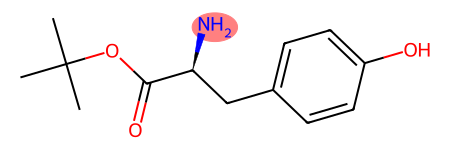

In [46]:
a2

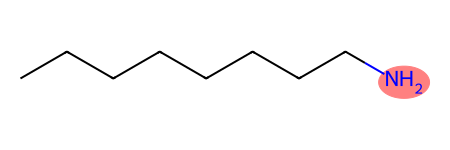

In [47]:
a3

In [49]:
def get_morgan_fragement_and_fingerprint(mol, matches, radius=3, fpSize=2048):
    """get morgran fragement and fingerprint, when is_feat is True, uses morgan feature fingerprint

    Args:
        mol (Mol): molecule to get fragement and fingerprint
        matches (List[int]): list of atom indices to get fragement and fingerprint
        radius (int, optional): radius of the fingerprint. Defaults to 3.
        fpSize (int, optional): fpsize of the finterprint. Defaults to 2048.

    Returns:
        Tuple[List[Tuple[Mol, int, Dict[int, Tuple]]], ExplicitBitVect]: return tuple of fragements and fingerprint
    """
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateBitInfoMap()
    fp = fpgen.GetFingerprint(mol, fromAtoms=matches, additionalOutput=ao)
    fragments: List[Tuple[Mol, Tuple[int, int], Dict[int, Tuple]]] = [
        (mol, x, ao.GetBitInfoMap()) for x in ao.GetBitInfoMap()
    ]
    return fragments, fp

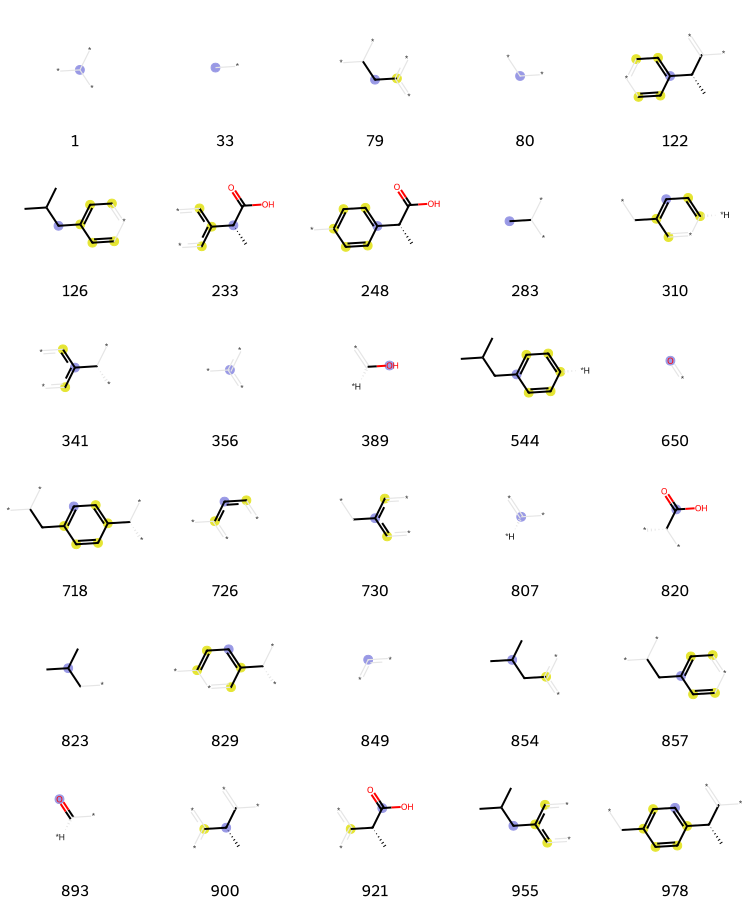

In [75]:
# Morgan fingerprint
matches = []
fragment, fp = get_morgan_fragement_and_fingerprint(mol=ibuprofen, matches=matches, radius=3, fpSize=1024)
Draw.DrawMorganBits(fragment[:], molsPerRow=5, legends=[str(x[1]) for x in fragment])

Morgan feature rooted fingerprint has 4 fragments


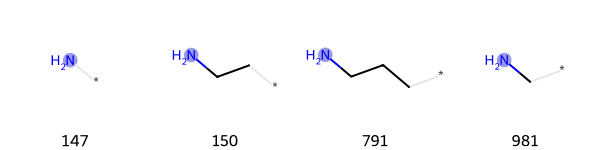

In [69]:
matches = [x[0] for x in a1.GetSubstructMatches(amine)]
a1_fragment, a1_fp = get_morgan_fragement_and_fingerprint(mol=a1, matches=matches, radius=3, fpSize=1024)
print(f"Morgan feature rooted fingerprint has {len(fragment)} fragments")
Draw.DrawMorganBits(a1_fragment[:], molsPerRow=4, legends=[str(x[1]) for x in a1_fragment])

Morgan feature rooted fingerprint has 4 fragments


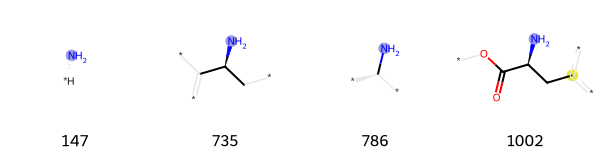

In [67]:
matches = [x[0] for x in a2.GetSubstructMatches(amine)]
a2_fragment, a2_fp = get_morgan_fragement_and_fingerprint(mol=a2, matches=matches, radius=3, fpSize=1024)
print(f"Morgan feature rooted fingerprint has {len(a2_fragment)} fragments")
Draw.DrawMorganBits(a2_fragment[:], molsPerRow=4, legends=[str(x[1]) for x in a2_fragment])

Morgan feature rooted fingerprint has 4 fragments


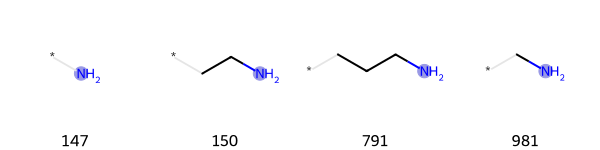

In [68]:
matches = [x[0] for x in a3.GetSubstructMatches(amine)]
a3_fragment, a3_fp = get_morgan_fragement_and_fingerprint(mol=a3, matches=matches, radius=3, fpSize=1024)
print(f"Morgan feature rooted fingerprint has {len(a3_fragment)} fragments")
Draw.DrawMorganBits(a3_fragment[:], molsPerRow=4, legends=[str(x[1]) for x in a3_fragment])

In [61]:
print(f"Tanimoto similarity between reactive mol and unknown 1: {DataStructs.TanimotoSimilarity(a1_fp, a2_fp)}")
print(f"Tanimoto similarity between reactive mol and unknown 2: {DataStructs.TanimotoSimilarity(a1_fp, a3_fp)}")

Tanimoto similarity between reactive mol and unknown 1: 0.14285714285714285
Tanimoto similarity between reactive mol and unknown 2: 1.0


## 3. Substructure matching using RdKit's FilterCatalog

RdKit provides a filter catalog that contains a list of substructures. Each substructure is associated with a filter name. The filter catalog is stored in a file called filterCatalog.xml. You can find the file in the data folder of your RDKit installation.

List of substructures can be found here:
https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/FilterCatalog/README

In [83]:
# You can also add your filter catalog of your own! 
amine_smart = "[N;!H0;$(N-[#6]);!$(N-[!#6;!#1;!#7]);!$(N-C=[O,N,S])]"
matcher = SmartsMatcher('amine', amine_smart, 1, 3) 
print(f"reactive mol matches amine smarts: {matcher.HasMatch(a1)}")

reactive mol matches amine smarts: False


## 4. Synple's substructure filtering function 

In synple, we have a list of filters per reaction to make sure the reactivies of building blocks. So we use following function to filter the building blocks.

In [ ]:
def return_fg_filtered_idx(
    mols: List[Mol], fg_filters: List[Dict[str, Tuple[str, int, int]]]
) -> List[int]:
    """filter building blocks that only includes or excludes given functional groups
    then return the index of the valid building blocks

    Args:
        mols (List[Mol]): List of Mols of building blocks
        fg_filters (List[Dict[str, Tuple[str, int, int]]]): functional group list to include or exclude
            format: [{fg_nm: [fg_smarts, min_num, max_num]}, ...]

    Returns:
        List[int]: List of valid building block index
    """
    valid_idx: List[int] = []
    for ii, mol in enumerate(mols):
        # filter with functional groups
        has_match: bool = True
        for fg in fg_filters:
            for fg_nm, fg_props in fg.items():
                fg_smarts, min_num, max_num = fg_props
                matcher_fg = SmartsMatcher(fg_nm, fg_smarts, min_num, max_num)
                has_match &= matcher_fg.HasMatch(mol)

        if has_match:  # fc.HasMatch(mol):
            valid_idx.append(ii)

    return valid_idx